### Define dataset

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt

class ShapesDataset(Dataset):
    def __init__(self, num_images, resolution=64, radius=8, transform=None):
        """
        Initializes the dataset.

        Parameters:
        - num_images: Integer specifying the number of images in the dataset.
        - transform: Optional torchvision transforms to apply to the images.
        """
        self.num_images = num_images
        self.shapes = ['triangle', 'circle', 'square']
        self.canvas_size = resolution
        self.transform = transform
        self.shape_to_idx = {'triangle': 0, 'circle': 1, 'square': 2}
        self.idx_to_shape = {0: 'triangle', 1: 'circle', 2: 'square'}
        self.radius = radius
        # Define bounding box margins for different shapes
        self.shape_bounds = {
            'circle': lambda r: (2*r, 2*r),  # diameter x diameter
            'square': lambda r: (2*r, 2*r),  # side x side
            'triangle': lambda r: (2*r, int(2*r * (3**0.5) / 2))  # base x height
        }
        # Updated spatial relationship phrases including occlusion
        self.spatial_phrases = {
            'upper_left': ['to the upper left of', 'above and to the left of', 'diagonally up and left from'],
            'upper_right': ['to the upper right of', 'above and to the right of', 'diagonally up and right from'],
            'lower_left': ['to the lower left of', 'below and to the left of', 'diagonally down and left from'],
            'lower_right': ['to the lower right of', 'below and to the right of', 'diagonally down and right from'],
            'above': ['above', 'directly above', 'higher than'],
            'below': ['below', 'directly below', 'lower than'],
            'left': ['to the left of', 'left of'],
            'right': ['to the right of', 'right of'],
            'in_front': ['in front of', 'overlapping'],
            'behind': ['behind', 'partially hidden by']
        }

    def get_shape_bounds(self, shape, location):
        """
        Get the bounding box for a shape at a given location.
        Returns (left, top, right, bottom)
        """
        x, y = location
        width, height = self.shape_bounds[shape](self.radius)
        
        if shape == 'triangle':
            # Triangle's bounding box is centered horizontally, but offset vertically
            # due to its center of mass being lower
            return (
                x - width//2,          # left
                y - height//3,         # top (offset to match draw_shape_on_image)
                x + width//2,          # right
                y + height*2//3        # bottom
            )
        else:
            # Circle and square are centered on their position
            return (
                x - width//2,    # left
                y - height//2,   # top
                x + width//2,    # right
                y + height//2    # bottom
            )

    def check_occlusion(self, shape1, loc1, shape2, loc2):
        """
        Checks if two shapes overlap based on their bounding boxes.
        Also determines which shape is visually in front based on drawing order.
        
        Returns:
        - (bool, str): (is_occluding, relationship)
            relationship can be 'in_front', 'behind', or None
        """
        box1 = self.get_shape_bounds(shape1, loc1)
        box2 = self.get_shape_bounds(shape2, loc2)
        
        # Check if bounding boxes overlap
        overlap = not (box1[2] < box2[0] or    # box1 right < box2 left
                      box1[0] > box2[2] or    # box1 left > box2 right
                      box1[3] < box2[1] or    # box1 bottom < box2 top
                      box1[1] > box2[3])      # box1 top > box2 bottom
        
        return overlap

    def generate_caption(self, shape1_idx, shape2_idx, loc1, loc2, color1=None, color2=None, is_shape1_on_top=None):
        """
        Generates a natural language caption describing the spatial relationship between two shapes.
        """
        shape1_name = self.idx_to_shape[shape1_idx]
        shape2_name = self.idx_to_shape[shape2_idx]
        
        # Check for occlusion
        is_occluding = self.check_occlusion(shape1_name, loc1, shape2_name, loc2)
        
        if is_occluding:
            if is_shape1_on_top:
                relation = random.choice(self.spatial_phrases['behind'])  # shape1 is drawn last, so shape2 is behind
            else:
                relation = random.choice(self.spatial_phrases['in_front'])  # shape1 is drawn first, so shape2 is in front
        else:
            # ... [rest of the existing spatial relationship logic] ...
            # Calculate position differences
            x1, y1 = loc1
            x2, y2 = loc2
            dx = x1 - x2
            dy = y1 - y2
            threshold = 5

            if abs(dx) <= threshold:
                if dy < 0:
                    relation = random.choice(self.spatial_phrases['above'])
                else:
                    relation = random.choice(self.spatial_phrases['below'])
            elif abs(dy) <= threshold:
                if dx < 0:
                    relation = random.choice(self.spatial_phrases['left'])
                else:
                    relation = random.choice(self.spatial_phrases['right'])
            else:
                if dx < 0 and dy < 0:
                    relation = random.choice(self.spatial_phrases['upper_left'])
                elif dx < 0 and dy > 0:
                    relation = random.choice(self.spatial_phrases['lower_left'])
                elif dx > 0 and dy < 0:
                    relation = random.choice(self.spatial_phrases['upper_right'])
                else:
                    relation = random.choice(self.spatial_phrases['lower_right'])

        if color1 is not None and color2 is not None:
            shape1_qualifier = random.choice([color1, ""])
            shape2_qualifier = random.choice([color2, ""])
            caption = f"{shape1_qualifier} {shape1_name} is {relation} {shape2_qualifier} {shape2_name}"
        else:
            caption = f"{shape1_name} is {relation} {shape2_name}"
        
        return caption

    def __len__(self):
        return self.num_images

    def draw_shape_on_image(self, img, shape, location, color='black'):
        """
        Draws a specified shape at a given location on the provided image.

        Parameters:
        - img: PIL Image object to draw on.
        - shape: String specifying the shape ('triangle', 'circle', 'square').
        - location: Tuple (x, y) specifying the location of the shape's center.

        Returns:
        - img: PIL Image object with the shape drawn on it.
        """
        draw = ImageDraw.Draw(img)
        x, y = location

        if shape == 'circle':
            r = self.radius  # Radius
            leftUpPoint = (x - r, y - r)
            rightDownPoint = (x + r, y + r)
            draw.ellipse([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'square':
            s = self.radius * 2  # Side length
            leftUpPoint = (x - s // 2, y - s // 2)
            rightDownPoint = (x + s // 2, y + s // 2)
            draw.rectangle([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'triangle':
            s = self.radius * 2  # Side length
            h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
            point1 = (x, y - h / 3)
            point2 = (x - s / 2, y + h * 2 / 3)
            point3 = (x + s / 2, y + h * 2 / 3)
            draw.polygon([point1, point2, point3], fill=color)

        else:
            raise ValueError("Shape must be 'triangle', 'circle', or 'square'.")

        return img

    def __getitem__(self, idx):
        """
        Generates one image and its labels.

        Parameters:
        - idx: Index of the image (not used as images are generated on-the-fly).

        Returns:
        - img: Tensor representing the image.
        - labels: Dictionary containing the shapes and locations of the objects.
        """
        # Create a blank image
        img = Image.new('RGB', (self.canvas_size, self.canvas_size), 'gray')

        # Randomly select two shapes, make sure they are different
        shape1 = random.choice(self.shapes)
        while True:
            shape2 = random.choice(self.shapes)
            if shape1 != shape2:
                break

        # Randomly select locations
        x1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        x2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)

        # Randomly decide drawing order to allow overlapping
        is_shape1_on_top = random.random() < 0.5
        if is_shape1_on_top:
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            shapes_order = [shape1, shape2]
            colors_order = ["red", "blue"]
            locations_order = [(x1, y1), (x2, y2)]
        else:
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            shapes_order = [shape2, shape1]
            colors_order = ["blue", "red"]
            locations_order = [(x2, y2), (x1, y1)]

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Encode labels and generate caption
        shape1_idx = self.shape_to_idx[shapes_order[0]]
        shape2_idx = self.shape_to_idx[shapes_order[1]]
        location1 = torch.tensor(locations_order[0], dtype=torch.float32)
        location2 = torch.tensor(locations_order[1], dtype=torch.float32)
        
        caption = self.generate_caption(shape1_idx, shape2_idx, locations_order[0], locations_order[1], 
                                     colors_order[0], colors_order[1], is_shape1_on_top)
        
        labels = {
            'shape1': shape1_idx,
            'location1': location1,
            'shape2': shape2_idx,
            'location2': location2,
            'caption': caption
        }
        return img, labels

Test 1: Random batch generation
Images batch shape: torch.Size([16, 3, 64, 64])
Sample of batch captions:
Image 0: red triangle is right of  square
Image 1: red square is behind blue triangle
Image 2: red square is to the upper right of blue triangle

Test 2: Specific cases visualization


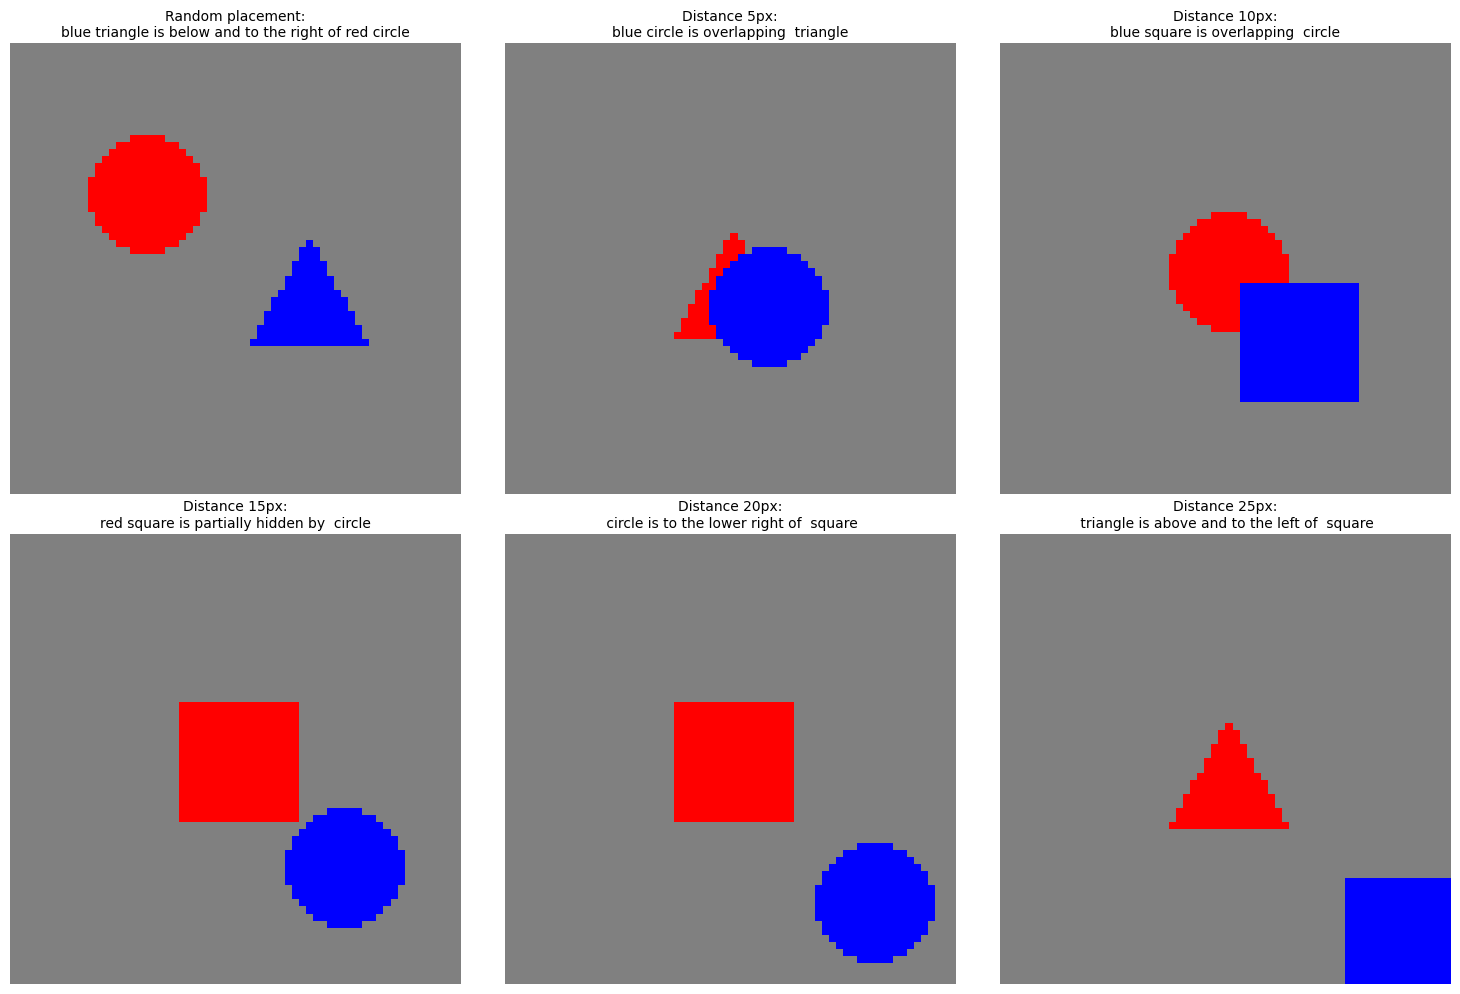


Test 3: Generated captions for different cases:
Caption: blue circle is overlapping  triangle
Caption:  circle is below and to the right of  square
Caption: red circle is to the upper left of  triangle
Caption: red square is diagonally up and left from blue circle
Caption: red triangle is partially hidden by blue circle


In [6]:
# Example usage:
if __name__ == '__main__':
    # Define any transforms (optional)
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Create the dataset
    dataset = ShapesDataset(num_images=1000, transform=transform)
    
    # Test 1: Random generation with DataLoader
    print("Test 1: Random batch generation")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    for images, labels in dataloader:
        print(f"Images batch shape: {images.size()}")
        print("Sample of batch captions:")
        # Print first 3 captions from batch
        for i in range(min(3, len(images))):
            print(f"Image {i}: {labels['caption'][i]}")
        break
    
    # Test 2: Specific cases including occlusion
    print("\nTest 2: Specific cases visualization")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Case 1: Original random placement
    img, lbl = dataset[0]
    img_np = img.permute(1, 2, 0).numpy()
    axes[0].imshow(img_np)
    axes[0].set_title(f"Random placement:\n{lbl['caption']}", fontsize=10, wrap=True)
    axes[0].axis('off')
    
    # Case 2-5: Force overlapping shapes by modifying __getitem__
    def get_overlapping_sample(dataset, center_distance):
        """Helper function to generate overlapping shapes"""
        # Create a blank image
        img = Image.new('RGB', (dataset.canvas_size, dataset.canvas_size), 'gray')
        
        # Select different shapes
        shape1 = random.choice(dataset.shapes)
        shape2 = random.choice([s for s in dataset.shapes if s != shape1])
        
        # Set center positions to force overlap
        center_x = dataset.canvas_size // 2
        center_y = dataset.canvas_size // 2
        
        # Position shape2 slightly offset from shape1
        x1 = center_x
        y1 = center_y
        x2 = center_x + center_distance
        y2 = center_y + center_distance
        
        # Randomly decide drawing order
        is_shape1_on_top = random.random() < 0.5
        if is_shape1_on_top:
            img = dataset.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            img = dataset.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            shapes_order = [shape1, shape2]
            locations_order = [(x1, y1), (x2, y2)]
            colors_order = ["red", "blue"]
        else:
            img = dataset.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            img = dataset.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            shapes_order = [shape2, shape1]
            locations_order = [(x2, y2), (x1, y1)]
            colors_order = ["blue", "red"]
            
        if dataset.transform:
            img = dataset.transform(img)
        else:
            img = transforms.ToTensor()(img)
            
        shape1_idx = dataset.shape_to_idx[shapes_order[0]]
        shape2_idx = dataset.shape_to_idx[shapes_order[1]]
        location1 = torch.tensor(locations_order[0], dtype=torch.float32)
        location2 = torch.tensor(locations_order[1], dtype=torch.float32)
        
        caption = dataset.generate_caption(shape1_idx, shape2_idx, locations_order[0], 
                                        locations_order[1], colors_order[0], colors_order[1],
                                        is_shape1_on_top)
        
        labels = {
            'shape1': shape1_idx,
            'location1': location1,
            'shape2': shape2_idx,
            'location2': location2,
            'caption': caption
        }
        return img, labels
    
    # Generate overlapping samples with different distances
    distances = [5, 10, 15, 20, 25]  # Different center distances to test occlusion
    for i, distance in enumerate(distances, 1):
        if i < len(axes):
            img, lbl = get_overlapping_sample(dataset, distance)
            img_np = img.permute(1, 2, 0).numpy()
            axes[i].imshow(img_np)
            axes[i].set_title(f"Distance {distance}px:\n{lbl['caption']}", fontsize=10, wrap=True)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print example captions for different spatial relationships
    print("\nTest 3: Generated captions for different cases:")
    for _ in range(5):
        _, lbl = get_overlapping_sample(dataset, random.choice([5, 10, 15, 20, 25]))
        print(f"Caption: {lbl['caption']}")

### Make a pixart trainable dataset

In [5]:
import os
from tqdm.notebook import tqdm
from datasets import load_dataset
import json
from os.path import join
transform = transforms.Compose([
    lambda x: x.convert("RGB"),
    # Add more transforms if needed
])
resolution = 128
dataset = ShapesDataset(num_images=10000, resolution=resolution, radius=16,
                        transform=transform)

root_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2"
images_dir = "images"
captions_dir = "captions"

images_dir_absolute = join(root_dir, images_dir)
captions_dir_absolute = join(root_dir, captions_dir)

if not os.path.exists(root_dir):
    os.makedirs(join(root_dir, images_dir))

if not os.path.exists(join(root_dir, images_dir)):
    os.makedirs(join(root_dir, images_dir))
if not os.path.exists(join(root_dir, captions_dir)):
    os.makedirs(join(root_dir, captions_dir))

image_format = "png"
json_name = "partition/data_info.json"
if not os.path.exists(join(root_dir, "partition")):
    os.makedirs(join(root_dir, "partition"))

absolute_json_name = join(root_dir, json_name)
data_info = []

for order, (image, labels) in tqdm(enumerate(dataset)): 
    if order >= 10000:
        break
    image = image
    image.save(f"{images_dir_absolute}/{order}.{image_format}")
    with open(f"{captions_dir_absolute}/{order}.txt", "w") as text_file:
        text_file.write(labels["caption"])
    
    width, height = resolution, resolution
    ratio = 1
    data_info.append({
        "height": height,
        "width": width,
        "ratio": ratio,
        "path": f"{order}.{image_format}", # images/ # if there is images/ in the path it will cause error in InternalData.py L55, L56. 
        "prompt": labels["caption"],
    })        

with open(absolute_json_name, "w") as json_file:
    json.dump(data_info, json_file)

0it [00:00, ?it/s]

In [11]:
with open(absolute_json_name, "w") as json_file:
    json.dump(data_info, json_file)

In [12]:
absolute_json_name

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot/partition/data_info.json'

## Extract features

In [2]:
%cd ../PixArt-alpha
!python ~/Github/DiffusionObjectRelation/PixArt-alpha/tools/extract_features.py \
    --img_size 128 \
    --max_tokens 20 \
    --dataset_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot2" \
    --json_path $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot2/partition/data_info.json" \
    --t5_save_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot2/caption_feature_wmask" \
    --vae_save_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot2/img_vae_features" \
    --pretrained_models_dir $STORE_DIR"/DL_Projects/PixArt/output/pretrained_models"

/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is exp

In [11]:
!du -sh $STORE_DIR/DL_Projects/PixArt/objectRel_pilot2/*

2.4G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/caption_feature_wmask
40M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/captions
40M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/images
118M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/img_vae_features_128resolution
1.2M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/partition


In [14]:
!python ~/Github/DiffusionObjectRelation/PixArt-alpha/tools/extract_features.py \
    --img_size 128 \
    --dataset_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot" \
    --json_path $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot/partition/data_info.json" \
    --t5_save_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot/caption_feature_wmask" \
    --vae_save_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot/img_vae_features" \
    --pretrained_models_dir $STORE_DIR"/DL_Projects/PixArt/output/pretrained_models"

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior wi

In [15]:
1000 * 10000 /256

39062.5